In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\T.B\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
print("English stopwords loaded successfully")
print(f"Total stopwords: {len(stopwords.words('english'))}")

English stopwords loaded successfully
Total stopwords: 198


In [3]:
# Load the dataset
true_news = pd.read_csv("True.csv")
fake_news = pd.read_csv("Fake.csv")

In [4]:
# Merge the datasets and add labels
true_news["label"] = 1
fake_news["label"] = 0
news_dataset = pd.concat([true_news, fake_news], axis=0)

# Shuffle the dataset
news_dataset = news_dataset.sample(frac=1)

# Reset the index
news_dataset.reset_index(inplace=True, drop=True)

In [5]:
news_dataset.head()

,title,text,subject,date,label
0,"John McCain Throws Tantrum, Decries Trump for ...",21st Century Wire says A predictable reaction ...,Middle-east,"April 1, 2017",0
1,‘Meet Jeb’ – Going For Your Sympathy Vote,"21st Century Wire says As Republican, Ted Cruz...",US_News,"February 4, 2016",0
2,Pres. Obama Just Saved Chelsea Manning On His...,Presidential commutations and pardons are not ...,News,"January 17, 2017",0
3,Details of military transgender policy being w...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"July 26, 2017",1
4,"Donald Trump Attacks Obama, Says He Understan...",It was just a few days ago that President Bara...,News,"April 4, 2016",0


In [6]:
print(f"Dataset shape: {news_dataset.shape}")

Dataset shape: (44898, 5)


In [7]:
print(news_dataset.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [8]:
news_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [9]:
news_dataset.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
news_dataset["content"] = news_dataset["title"] + " " + news_dataset["text"]

X = news_dataset["content"].values
Y = news_dataset["label"].values

In [11]:
# Display first content sample
print("Sample content:")
print(X[0][:200])

Sample content:
John McCain Throws Tantrum, Decries Trump for ‘Letting Assad Stay’ 21st Century Wire says A predictable reaction from a pair of increasingly desperate politicians.Perennial war hawks Senators John McC


In [12]:
# Display target distribution
print("Target distribution:")
print(pd.Series(Y).value_counts())

Target distribution:
0    23481
1    21417
Name: count, dtype: int64


In [13]:
# Stemming function
port_stem = PorterStemmer()

def stemming(content):
    
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X)

print(f"Vectorized data shape: {X.shape}")

Vectorized data shape: (44898, 5000)


In [15]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (35918, 5000)
Testing data shape: (8980, 5000)


In [16]:
# Model training
model = LogisticRegression(max_iter=1000)

model.fit(X_train, Y_train)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [17]:
# Make predictions on test data
X_test_prediction = model.predict(X_test)

# Calculate accuracy
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print(f"Accuracy score of the test data: {test_data_accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(Y_test, X_test_prediction, target_names=['Fake', 'Real']))

Accuracy score of the test data: 0.9878

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4652
        Real       0.99      0.99      0.99      4328

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



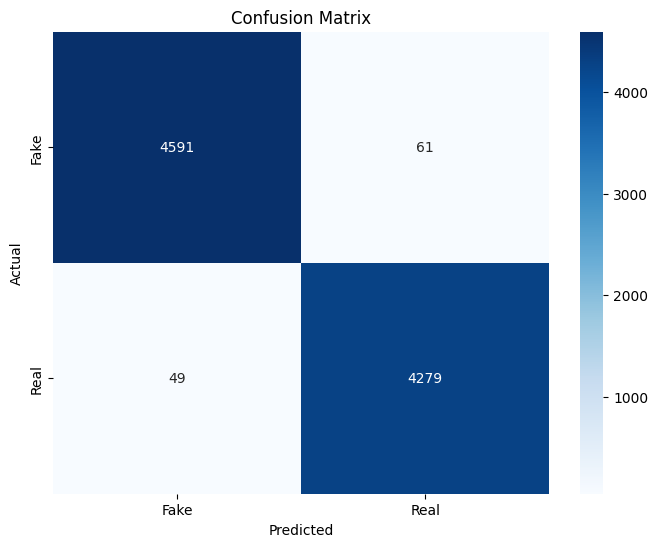

In [18]:
# Visualize confusion matrix
cm = confusion_matrix(Y_test, X_test_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [21]:
# Predict new news articles
test_articles = [
    "The economy is improving and stock markets are up.",
    "Doctors confirm a new vaccine has passed all clinical trials.",
    "You won't believe this shocking secret politicians are hiding!"
]

# Vectorize the test articles
X_new = vectorizer.transform(test_articles)

# Make predictions
predictions = model.predict(X_new)

# Display results with more clarity
print("=" * 60)
print("NEWS CLASSIFICATION RESULTS")
print("=" * 60)

for i, (article, prediction) in enumerate(zip(test_articles, predictions), 1):
    status = "REAL" if prediction == 1 else "FAKE"
    print(f"\nArticle {i}: {status}")
    print(f"Text: {article[:70]}...")
    
print("\n" + "=" * 60)

NEWS CLASSIFICATION RESULTS

Article 1: FAKE
Text: The economy is improving and stock markets are up....

Article 2: FAKE
Text: Doctors confirm a new vaccine has passed all clinical trials....

Article 3: FAKE
Text: You won't believe this shocking secret politicians are hiding!...

